In [74]:
import utilities as utils
import configs_py3 as configs
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, roc_curve, PrecisionRecallDisplay
from nltk.corpus import wordnet
import importlib
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
importlib.reload(configs)
importlib.reload(utils)


In [ ]:
val_df = utils.load_dataset(split='val')
val_df = utils.get_preds(val_df) 

In [ ]:
objects_in_image = []
for index, row in val_df.iterrows():
    imgId = row['image_id'] 
    imgFilename = 'COCO_' + configs.dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
    img_path = configs.imgDir + imgFilename
    results = utils.run_object_detection(img_path, threshold=0.5)
    objects_in_image.append(utils.get_objects_in_image(results))

val_df["objects_in_image"] = objects_in_image
    
    

In [88]:
# store val_df
val_df.to_csv(f"{configs.ROOT}/output/{configs.today}-val_df-object-detection.csv")


In [4]:
val_df = pd.read_csv(f"{configs.ROOT}/output/{configs.today}-val_df-object-detection.csv")

In [ ]:
for threshold in np.arange(0.1, 1.0, 0.1):
    val_df = utils.get_similarities(val_df, mode='random', threshold=threshold)
    val_df = utils.get_similarities(val_df, mode='original', threshold=threshold)

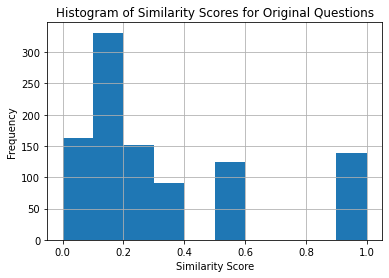

In [7]:
val_df.original_similarity_score.hist()
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.title("Histogram of Similarity Scores for Original Questions")
plt.show()

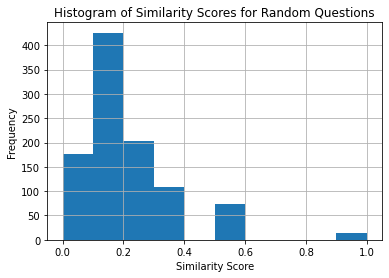

In [8]:
val_df.random_similarity_score.hist()
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.title("Histogram of Similarity Scores for Random Questions")
plt.show()

In [56]:
probas_pred_original = val_df[f"original_similarity_score"].tolist()
y_true_original = np.ones(len(probas_pred_original)).tolist()
probas_pred_random = val_df[f'random_similarity_score'].tolist()
y_true_random = np.zeros(len(probas_pred_random)).tolist()

probas_pred = probas_pred_original + probas_pred_random
y_true = y_true_original + y_true_random

Best Threshold=0.000, F-Score=0.667


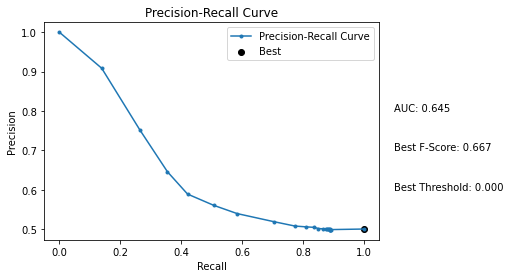

In [61]:
precision, recall, thresholds = precision_recall_curve(y_true, probas_pred)
auc_val = auc(recall, precision)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%.3f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.annotate(f"Best Threshold: {thresholds[ix]:.3f}", (recall[ix], precision[ix]), xytext=(recall[ix]+0.1, precision[ix]+0.1))
plt.annotate(f"Best F-Score: {fscore[ix]:.3f}", (recall[ix], precision[ix]), xytext=(recall[ix]+0.1, precision[ix]+0.2))
plt.annotate(f"AUC: {auc_val:.3f}", (recall[ix], precision[ix]), xytext=(recall[ix]+0.1, precision[ix]+0.3))
plt.legend()
plt.show()

Best Threshold=0.500000


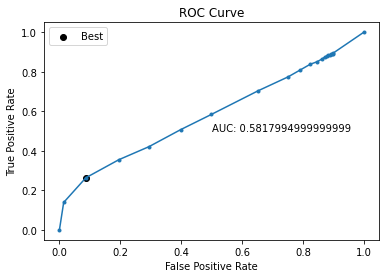

In [62]:
fpr, tpr, thresholds = roc_curve(y_true, probas_pred)
auc_val = auc(fpr, tpr)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.plot(fpr, tpr, marker='.')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.annotate(f"AUC: {auc_val}", (0.5, 0.5), xytext=(0.5, 0.5))
plt.legend()
plt.show()

In [79]:
percentage_correct_random = []
percentage_correct_original = []
pecentage_correct_average = []


for threshold in np.arange(0.1, 1.0, 0.1):
    percentage_correct_random.append(sum(val_df.random_similarity_score > threshold) / len(val_df))
    percentage_correct_original.append(sum(val_df.original_similarity_score > threshold) / len(val_df))
    pecentage_correct_average.append((((sum(val_df.random_similarity_score > threshold) / len(val_df)) + (sum(val_df.original_similarity_score > threshold) / len(val_df)))/2))



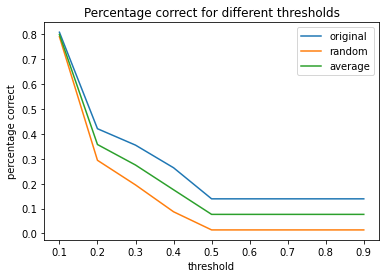

In [80]:

plt.plot(np.arange(0.1, 1.0, 0.1), percentage_correct_original, label="original")
plt.plot(np.arange(0.1, 1.0, 0.1), percentage_correct_random, label="random")
plt.plot(np.arange(0.1, 1.0, 0.1), pecentage_correct_average, label="average")
plt.legend()
plt.xlabel("threshold")
plt.ylabel("percentage correct")
plt.title("Percentage correct for different thresholds")
plt.show()

In [81]:
val_df[f"original_similarity_score"].describe(), val_df[f"random_similarity_score"].describe()

(count    1000.000000
 mean        0.315289
 std         0.308794
 min         0.000000
 25%         0.125000
 50%         0.200000
 75%         0.500000
 max         1.000000
 Name: original_similarity_score, dtype: float64,
 count    1000.000000
 mean        0.196648
 std         0.157214
 min         0.000000
 25%         0.125000
 50%         0.142857
 75%         0.250000
 max         1.000000
 Name: random_similarity_score, dtype: float64)

In [82]:
def evaluate(threshold=0.3):
    is_related = []
    modified_output = []
    threshold = round(threshold, 1)
    for index, row in val_df.iterrows():
        
        question = row['random_question'] if index >= len(val_df)//2 else row['original_question']
    
        is_random = True if index >= len(val_df)//2 else False
        
        if is_random:
            question_is_related = 1 if row[f"random_is_similar_{threshold}"] == 1 else 0
        
        else:
            question_is_related = 1 if row[f"original_is_similar_{threshold}"] == 1 else 0
        
        is_related.append(question_is_related)
        modified_output.append(row.original_model_outputs) if question_is_related == 1 else modified_output.append("ABSTAIN")
            
    val_df["modified_output"] = modified_output

    y_pred = [1 if x == "ABSTAIN" or x == "nothing" else 0 for x in val_df["modified_output"].tolist()]
    y_true = [1 if i >= len(val_df) // 2 else 0 for i in range(len(val_df))]

    confusion_matrix_abstain = confusion_matrix(y_true, y_pred)
    classification_report_abstain = classification_report(y_true, y_pred, target_names=["Related", "Unrelated"])
    print(f"threshold: {threshold}")
    print(classification_report_abstain)
    return y_true, y_pred

In [83]:
# abstain if model output is nothing, or if none of the objects in the image are in the question
for threshold in np.arange(0.1, 1.0, 0.1):
    y_true, y_pred = evaluate(threshold=threshold)


threshold: 0.1
              precision    recall  f1-score   support

     Related       0.54      0.82      0.65       500
   Unrelated       0.62      0.29      0.39       500

    accuracy                           0.56      1000
   macro avg       0.58      0.56      0.52      1000
weighted avg       0.58      0.56      0.52      1000

threshold: 0.2
              precision    recall  f1-score   support

     Related       0.59      0.41      0.48       500
   Unrelated       0.55      0.71      0.62       500

    accuracy                           0.56      1000
   macro avg       0.57      0.56      0.55      1000
weighted avg       0.57      0.56      0.55      1000

threshold: 0.3
              precision    recall  f1-score   support

     Related       0.63      0.35      0.45       500
   Unrelated       0.55      0.79      0.65       500

    accuracy                           0.57      1000
   macro avg       0.59      0.57      0.55      1000
weighted avg       0.59      

In [84]:
best_threshold = 0.3
y_true, y_pred = evaluate(threshold=best_threshold)

threshold: 0.3
              precision    recall  f1-score   support

     Related       0.63      0.35      0.45       500
   Unrelated       0.55      0.79      0.65       500

    accuracy                           0.57      1000
   macro avg       0.59      0.57      0.55      1000
weighted avg       0.59      0.57      0.55      1000



In [85]:
val_df["modified_output"][:val_df.shape[0]//2].value_counts()

ABSTAIN         324
white             5
yellow            5
frisbee           5
cake              4
               ... 
digital           1
motel             1
forward           1
tennis shoes      1
main              1
Name: modified_output, Length: 131, dtype: int64

In [86]:
val_df["modified_output"][val_df.shape[0]//2:].value_counts()

ABSTAIN         389
nothing           7
black             5
white             3
blue              3
               ... 
against wall      1
oak               1
skis              1
grass             1
tennis shoes      1
Name: modified_output, Length: 84, dtype: int64

In [28]:
val_df.to_csv(f"{configs.ROOT}/output/{configs.today}-val_df-object-detection.csv")

In [170]:
val_df = pd.read_csv(f"{configs.ROOT}/output/{configs.today}-val_df-object-detection.csv")

In [196]:
for i, val in enumerate(y_pred):
    if y_true[i] != val:
        print(i, "raw_out", val_df["original_model_outputs"][i], "modified_out", val_df["modified_output"][i], "y_true", y_true[i], "y_pred", y_pred[i])

1 raw_out chocolate modified_out ABSTAIN y_true 0 y_pred 1
3 raw_out christmas modified_out ABSTAIN y_true 0 y_pred 1
4 raw_out white modified_out ABSTAIN y_true 0 y_pred 1
5 raw_out paper modified_out ABSTAIN y_true 0 y_pred 1
6 raw_out cinnamon modified_out ABSTAIN y_true 0 y_pred 1
7 raw_out kitchen modified_out ABSTAIN y_true 0 y_pred 1
8 raw_out black modified_out ABSTAIN y_true 0 y_pred 1
9 raw_out black and white modified_out ABSTAIN y_true 0 y_pred 1
10 raw_out pepperoni modified_out ABSTAIN y_true 0 y_pred 1
13 raw_out winter modified_out ABSTAIN y_true 0 y_pred 1
14 raw_out pizza modified_out ABSTAIN y_true 0 y_pred 1
16 raw_out fries modified_out ABSTAIN y_true 0 y_pred 1
17 raw_out flowers modified_out ABSTAIN y_true 0 y_pred 1
18 raw_out skiing modified_out ABSTAIN y_true 0 y_pred 1
20 raw_out sidewalk modified_out ABSTAIN y_true 0 y_pred 1
22 raw_out blue modified_out ABSTAIN y_true 0 y_pred 1
23 raw_out paint modified_out ABSTAIN y_true 0 y_pred 1
24 raw_out chinese modi